<a href="https://colab.research.google.com/github/adubowski/redi-xai/blob/main/classifier/test_blank_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Libraries and Initialise Parameters

In [ ]:
from google.colab import drive

import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj

import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset, Subset
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json

from matplotlib import pyplot as plt
plt.style.use('seaborn')
from matplotlib.pyplot import imshow

##### Mount Google Drive and create & save various directory paths

In [ ]:
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/redi-detecting-cheating"

with open(oj(dir_path, 'config.json')) as json_file:
    data = json.load(json_file)

model_path = oj(dir_path, data["model_folder"], "initial_classifier")
data_path = oj(dir_path, data["data_folder"])

seg_path  = oj(data_path, "patch-segmentation")
not_cancer_path = oj(data_path, "processed/no_cancer")
cancer_path = oj(data_path, "processed/cancer")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Parameters for standardising the data - taken from Rieger et al Github.
Need to check if these are specific to that project or to the VGG16 model.

In [ ]:
mean = np.asarray([0.485, 0.456, 0.406]) 
std = np.asarray([0.229, 0.224, 0.225])

##### Function to plot image and segmentation.

In [ ]:
def plot_lesion_and_seg(dataset, idx):
  """ 
  Input: 
    dataset   -   Tensor dataset of images. Contained in each element of the dataset is the image, label and segmentation.
    idx       -   The image index to plot.
  Returns:
    None      -   Plots the original lesion image and segmentation image to screen.
  """
  plt.style.use('default')
  fig, ax = plt.subplots(2, 1)

  # The axes have been swapped in the tensor dataset so that the colour channels are the first axis. Undo this with permute().
  # The image has been standardised, so multiply by the std and add to the mean to reverse this.
  orig_img = dataset[idx][0].permute(1, 2, 0).numpy()*std + mean
  ax[0].imshow(orig_img)

  ax[1].imshow(dataset[idx][2], cmap="Greys")   # Plot the segmentation

# plot_lesion_and_seg(not_cancer_dataset, 1100)       # Example.

def plot_lesion(datalist, idx):
  """ 
  Input: 
    dataset   -   Tensor dataset of images. Contained in each element of the dataset is the image, label and segmentation.
    idx       -   The image index to plot.
  Returns:
    None      -   Plots the original lesion image and segmentation image to screen.
  """
  plt.style.use('default')
  fig, ax = plt.subplots(1, 1)

  # The axes have been swapped in the tensor dataset so that the colour channels are the first axis. Undo this with permute().
  # The image has been standardised, so multiply by the std and add to the mean to reverse this.
  orig_img = datalist[idx].permute(1, 2, 0).numpy()*std + mean
  ax.imshow(orig_img)

##### Functions to get model predictions and AUC and F1 scores

In [ ]:
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score,precision_recall_curve, f1_score

def get_output(model, dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=False, num_workers=4)
    model = model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax()
    with torch.no_grad() :
        for inputs, labels, cd in data_loader:
          y.append((labels).cpu().numpy())
          y_hat.append(torch.nn.Softmax(dim=1)( model(inputs.cuda()))[:,1].detach().cpu().numpy()) # take the probability for cancer
    y = np.concatenate( y, axis=0 )
    y_hat = np.concatenate( y_hat, axis=0 )
    return y, y_hat 

def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys(): #for the gradient models we unfortunately saved all of the weights
            model.load_state_dict(weights)
        else:
            model.classifier.load_state_dict(weights)
        y, y_hat = get_output(model.classifier, dataset)
    else:   
        y, y_hat = get_output(model, dataset)
    auc = roc_auc_score(y, y_hat)
    f1 = np.asarray([f1_score(y, y_hat > x) for x in np.linspace(0.1,1, num = 10) if (y_hat >x).any() and (y_hat<x).any()]).max()
    return auc, f1

### Load Data
Load dataset from file to test effect of altering the patches.
The dataset has subsequently been saved as a tensor so it is quicker to read it in from this format. This section can be skipped.

##### Functions to read the various datasets

In [ ]:
def load_folder(path):
    list_files= os.listdir(path)
    num_files = min([2000, len(list_files)])
    imgs_np = np.empty((num_files,  299, 299,3))
    for i in tqdm(range(num_files)): 
        try:
            img = Image.open(oj(path, list_files[i]))
            imgs_np[i-num_files] = np.asarray(img)/255.0
            
            img.close()
        except:
            print(i)
    return imgs_np

def load_other_benign(path):
    list_files= os.listdir(path)
    num_files = min([2000, len(list_files)])
    imgs_np = np.empty((num_files,  299, 299,3))
    for i in tqdm(range(num_files, num_files+num_files)):   
        try:
            img = Image.open(oj(path, list_files[i]))
            imgs_np[i-num_files] = np.asarray(img)/255.0
            
            img.close()
        except:
            print(i)
    return imgs_np

def load_seg(path, orig_path):
    list_files= os.listdir(orig_path)
    num_files = min([2000, len(list_files)])
    imgs_np = np.zeros((num_files,  299, 299), dtype = np.bool)
    for i in tqdm(range(num_files, num_files+num_files)):
        if os.path.isfile(oj(path,  list_files[i])):
            img = Image.open(oj(path, list_files[i]))
            imgs_np[i-num_files] = np.asarray(img)[:,:,0] > 100
            img.close()
    return imgs_np

##### Load the cancer images and create a Tensor dataset.


In [ ]:
cancer_set = load_folder(cancer_path)
cancer_set -= mean[None, None, :]
cancer_set /= std[None, None, :]

cancer_targets = np.ones((cancer_set.shape[0])).astype(np.int64)

cancer_dataset = TensorDataset(torch.from_numpy(cancer_set.swapaxes(1,3).swapaxes(2,2)).float(), torch.from_numpy(cancer_targets),torch.from_numpy(np.zeros((len(cancer_set), 299, 299), dtype = np.bool)))
del cancer_set

gc.collect()

##### Load the non-cancer dataset and patch segmentations and create a Tensor dataset.

In [ ]:
not_cancer_set = load_other_benign(not_cancer_path)
not_cancer_set -= mean[None, None, :]
not_cancer_set /= std[None, None, :]
seg_set = load_seg(seg_path, not_cancer_path)

not_cancer_targets = np.zeros((not_cancer_set.shape[0])).astype(np.int64)

not_cancer_dataset = TensorDataset(torch.from_numpy(not_cancer_set.swapaxes(1,3).swapaxes(2,3)).float(), torch.from_numpy(not_cancer_targets),torch.from_numpy(seg_set))

del not_cancer_set
del seg_set

gc.collect()

##### Save the tensor datasets for speed of reading the next time.

In [ ]:
torch.save(cancer_dataset, oj(data_path, 'saved-tensors', 'cancer_dataset_0_196.pt'))
torch.save(not_cancer_dataset, oj(data_path, 'saved-tensors', 'not_cancer_dataset_2000_3999.pt'))

### Load Tensor Datasets
The data from the previous section has been previously saved as tensor datasets for speed of loading.

In [ ]:
# cancer_dataset = torch.load(oj(data_path, 'saved-tensors', 'cancer_dataset_0_196.pt'))
not_cancer_dataset = torch.load(oj(data_path, 'saved-tensors', 'not_cancer_dataset_2000_3999.pt'))

### Load Model
Model has been trained on the first 2,000 non-cancer images and the 196 cancer images.

In [ ]:
# Get a list of the models in the directory and their modified times 
model_list = [(f, os.path.getmtime(oj(dir_path,model_path,f))) for f in os.listdir(oj(dir_path, model_path)) if f.endswith('.pt')]
model_list.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place from most to least recent.

model_name = model_list[0][0]  # Take the most recent model.

model_dict = torch.load(oj(dir_path, model_path, model_name))

In [ ]:
model = models.vgg16(pretrained=True)

model.classifier[-1] = nn.Linear(4096, 2)

model.classifier.load_state_dict(model_dict)

device = torch.device(0)
model = model.to(device)

Free up space (model file is approx. 0.5GB)

In [ ]:
del model_dict, model_list
gc.collect()

53

##### Get and save predictions for the original images

In [ ]:
has_patch = [torch.max(seg) for im, label, seg in not_cancer_dataset]
patch_idx = [i for i in range(len(not_cancer_dataset)) if has_patch[i]]

dataset_with_patches = torch.utils.data.Subset(not_cancer_dataset, patch_idx)

preds_not_cancer = get_output(model, dataset_with_patches)

# np.save(oj(data_path, 'saved-tensors', 'not_cancer_preds_patches_2000_3999.npy'), preds_not_cancer[1])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
np.save(oj(data_path, 'saved-tensors', 'not_cancer_preds_patches_2000_3999.npy'), preds_not_cancer[1])

### Alter the images

##### **Update the images based on the segmentation mask.**
Loop through each element to update the image part.

Want to set the location of the patches to be zero, but the data is standardised so in fact we want to set it to -mean/std.

First get (~seg)*im to take the original image values in all locations except  the patch locations where it will be zero. 

Then update these patch locations by the 'shifted zero'. The resulting image should be three-dimensional so the inputs need to reshaped here to achieve this.

In [ ]:
def replace_patch(dataset, replacement_val):
  """ Function to replace the patches with a specific colour.
    dataset           -     Dataset containing images, labels, segmentation_masks
    replacement_val   -     The RGB value expressed as 1D array with length=3, where the values are floats between 0 and 1.
  Returns:
    updated_ims, labels, seg      (type: lists) Where the updated_ims are the altered images but the labels and segmentation are unchanged from the original.
  """
  shifted_val = (replacement_val-mean)/std    # The image data has been standardised - this is the value zero is shifted to. One value for each RGB channel.

  # Get the updated image based on the segmentation mask.
  updated_ims = [ ((~seg)*im + (seg.reshape(1,299,299) * shifted_val[:,None,None])).float()
                          for im, label, seg in dataset]
  labels = [label for _, label, _ in dataset]
  segs = [seg for _,_,seg in dataset]

  return updated_ims, labels, segs


# altered_ims_black, labels, segs  =   replace_patch(not_cancer_dataset, np.array([0,0,0]))
altered_ims_white,labels, segs       =   replace_patch(not_cancer_dataset, np.array([1,1,1]))
# altered_ims_grey, _, _          =   replace_patch(not_cancer_dataset, np.array([169/255, 169/255, 169/255]))     # Use RGB colour for 'darkgrey (SVG)'

In [ ]:
# Free up memory
del not_cancer_dataset
gc.collect()

In [ ]:
plot_lesion(altered_ims_white, 0)   # Show example image

In [ ]:
np.uint8(seg[0])

##### Save/Reload altered images

In [ ]:
## ------------------------------
## Save data in case of RAM crash.

with open(oj(data_path, 'saved-tensors', 'altered_ims_white.pkl'), 'wb') as f:
  pkl.dump(altered_ims_white, f)

# with open(oj(data_path, 'saved-tensors', 'labels.pkl'), 'wb') as f:
#   pkl.dump(labels, f)  

# with open(oj(data_path, 'saved-tensors', 'segs.pkl'), 'wb') as f:
#   pkl.dump(segs, f)  

## ------------------------------
## Load previously saved data.

# with open(oj(data_path, 'saved-tensors', 'altered_ims_white.pkl'), 'rb') as f:
#   altered_ims_white = pkl.load(f)

# with open(oj(data_path, 'saved-tensors', 'labels.pkl'), 'rb') as f:
#   labels = pkl.load(f)  

# with open(oj(data_path, 'saved-tensors', 'segs.pkl'), 'rb') as f:
#   segs = pkl.load(f)

##### Create Tensor Dataset for altered data

In [ ]:
not_cancer_altered = TensorDataset(torch.stack(altered_ims_white), torch.stack(labels), torch.stack(labels))

# del altered_ims_white, labels, segs
# gc.collect()

# torch.save(not_cancer_altered, oj(data_path, 'saved-tensors', 'not_cancer_altered_white_2000_3999.pt'))

##### Get predicted probabilities for the altered dataset

In [ ]:
labels, preds_altered = get_output(model, not_cancer_altered)

# np.save(oj(data_path, 'saved-tensors', 'not_cancer_preds_altered_white_2000_3999.npy'), preds_altered)

##### Reload previously saved predicted probabilities

In [ ]:
# preds_not_cancer  = np.load(oj(data_path, 'saved-tensors', 'not_cancer_preds_2000_3999.npy'))
# preds_altered     = np.load(oj(data_path, 'saved-tensors', 'not_cancer_preds_altered_2000_3999.npy'))

##### Compare probabilities for original and altered images

In [ ]:
def plot_compare_probs(probs_original, probs_altered, output_dir = oj(dir_path, 'plots'), output_add = None):
  """ Plots and saves three plots to compare the predicted probabilities before & after altering the images.
  Input: 
    probs_original, probs_altered     The output probabilities of the classification model for the original & altered image, as a Tensor, numpy array or list.
    output_dir                        The path to the directory for saving the plots.
    output_add                        An ID to add to the output filename. If left blank, then a random 10 digit ID is created.
  Returns:
    None    The three plots are saved to the relevant directory and also printed to screen.
  """
  if output_add is None:
    output_add = ''.join(["%s" % randint(0, 9) for num in range(0, 10)]) # Create a random ID to avoid overwriting previous files.

  ## Plot Histogram Comparison
  fig, ax = plt.subplots(2, 1, figsize = (10,8))

  ax[0].hist(probs_original)
  ax[0].set_title('Original')
  ax[0].set_xlabel('Predicted Probability')
  ax[0].set_ylabel('Number of Samples')
  ax[1].hist(probs_altered)
  ax[1].set_title('Patches Altered')
  ax[1].set_xlabel('Predicted Probability')
  ax[1].set_ylabel('Number of Samples')

  fig.suptitle('Predicted Probabilities Before & After Altering Patches', fontsize=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

  fig.savefig(oj(output_dir, 'Probs Comparison Hist ' + output_add + '.png'))
  plt.show()

  ## Plot Scatterplot Comparison.
  fig, ax = plt.subplots(1, 1, figsize = (8,8))

  ax.scatter(probs_original, probs_altered, alpha=0.4)
  ax.set_xlabel('Original', fontsize=12)
  ax.set_ylabel('Altered',fontsize=12)
  ax.set_title('Predicted Probs for Original Images & After Altering Patches', fontsize=16)

  fig.savefig(oj(output_dir, 'Probs Comparison Scatter ' + output_add + '.png'))
  plt.show()

  ## Calculate differences and plot histogram
  diff_preds = probs_altered - probs_original

  fig, ax = plt.subplots(1, 1, figsize = (8,8))

  hist_range = (-max(abs(diff_preds)), max(abs(diff_preds)))  # Make sure histogram is symmetric about zero.

  ax.hist(diff_preds, range = hist_range, bins = 20)
  ax.set_title('Histogram of differences in predicted probs after altering patches', fontsize=16)
  ax.set_ylabel('Number of Samples')
  ax.set_xlabel('Difference in Predicted Probability')

  fig.savefig(oj(output_dir, 'Diff in Predicted Probs Hist ' + output_add + '.png'))
  plt.show()

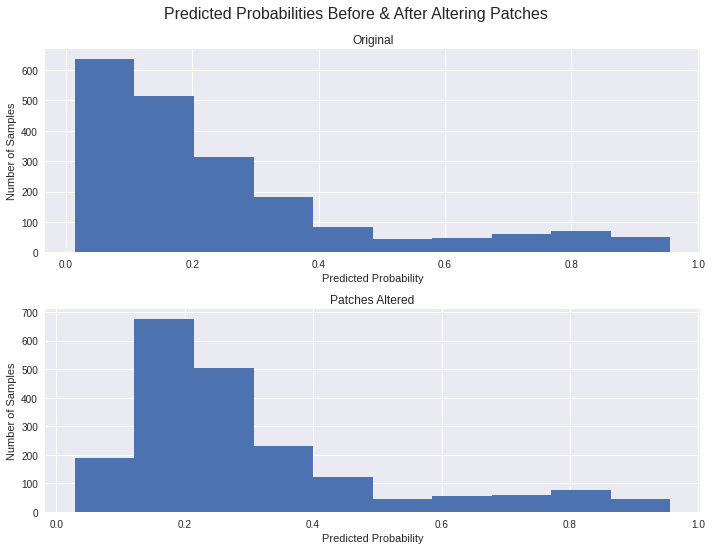

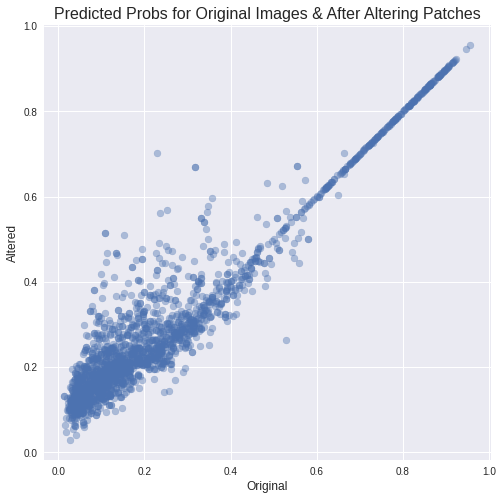

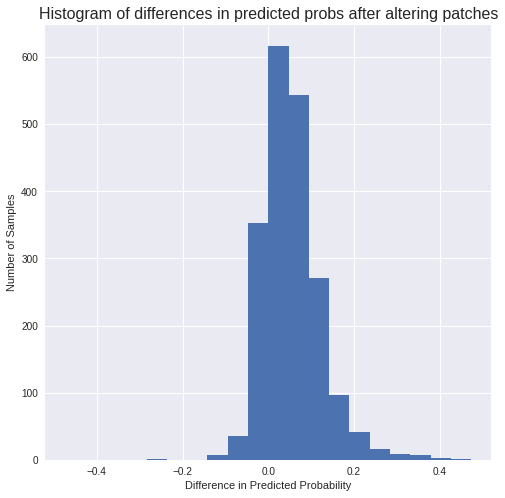

In [ ]:
plot_compare_probs(preds_not_cancer, preds_altered,output_add='(white)')